# Example 2.
# Detecting $f_0$ and Onsets from Out-Of-Domain Samples and Optimising Karplus-Strong Coefficients with Gradient Descent

## Detecting $f_0$ and onsets

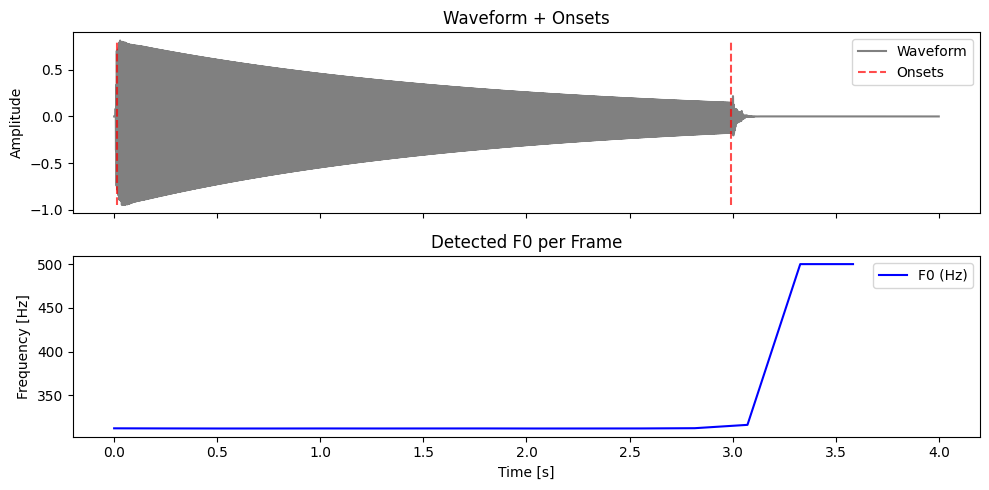

In [18]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from ddsp.utils import detect_f0, detect_onsets

sr = 16000
frame_hop = 4096

x, sr = librosa.load("target_audio/test.wav", sr=sr, mono=True)
onset_samples = detect_onsets(x, sr)
f0 = detect_f0(x, sr, hop_length=frame_hop, frame_length=frame_hop)

# Plot
t_audio = np.arange(len(x)) / sr
t_f0 = np.arange(len(f0)) * frame_hop / sr
t_onsets = onset_samples / sr
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Waveform with onsets
ax[0].plot(t_audio, x, color="gray", label="Waveform")
ax[0].vlines(t_onsets, ymin=x.min(), ymax=x.max(),
             color="red", linestyle="--", alpha=0.7, label="Onsets")
ax[0].set_title("Waveform + Onsets")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

# F0 contour
ax[1].plot(t_f0, f0, color="blue", label="F0 (Hz)")
ax[1].set_title("Detected F0 per Frame")
ax[1].set_ylabel("Frequency [Hz]")
ax[1].set_xlabel("Time [s]")
ax[1].legend()

plt.tight_layout()
plt.show()

## Creating bursts of length $f_s/f_0$ at onsets

### Plotter utility

In [19]:
def plot_waveforms(
    signals,
    titles=None,
    labels=None,
    sample_rate=16000,
    figsize=(10, 2.5),
    sharex=True
):
    num_plots = len(signals)
    fig, axs = plt.subplots(num_plots, 1, figsize=(figsize[0], figsize[1] * num_plots), sharex=sharex)

    # Make axs iterable even if there's only one subplot
    if num_plots == 1:
        axs = [axs]

    for i, ax in enumerate(axs):
        subplot_signals = signals[i] if isinstance(signals[i], (list, tuple)) else [signals[i]]
        t = torch.arange(subplot_signals[0].numel()) / sample_rate

        for j, y in enumerate(subplot_signals):
            label = None
            if labels is not None:
                if isinstance(labels[0], (list, tuple)):
                    label = labels[i][j] if i < len(labels) and j < len(labels[i]) else None
                else:
                    label = labels[j] if j < len(labels) else None
            ax.plot(t, y.detach().cpu(), label=label)

        if titles and i < len(titles):
            ax.set_title(titles[i])
        ax.set_ylabel("Amplitude")
        if label:
            ax.legend()

    axs[-1].set_xlabel("Time [s]")
    plt.tight_layout()
    plt.show()

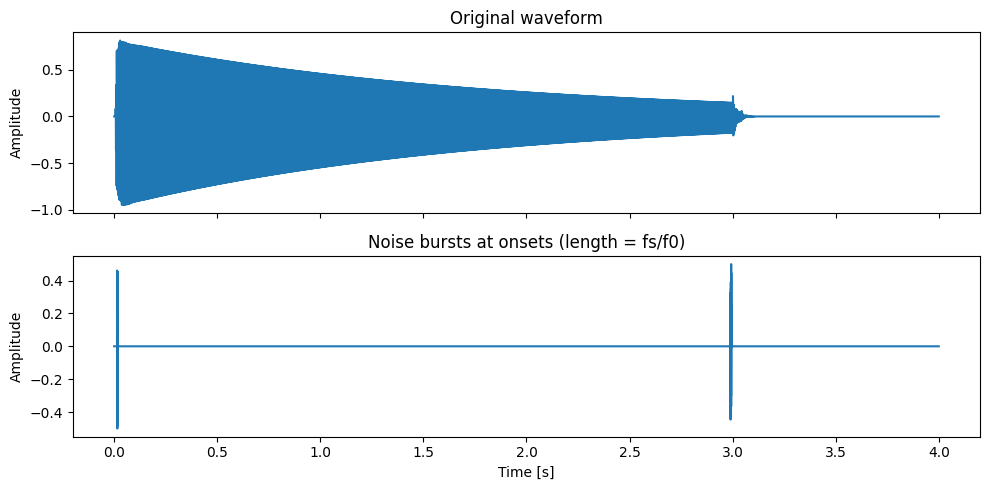

In [20]:
import torch
from ddsp.utils import bursts_at_onsets

bursts = bursts_at_onsets(x, sr, onset_samples, f0, burst_range=0.5, seed=42)
plot_waveforms(
    [torch.tensor(x), torch.tensor(bursts)],
    titles=["Original waveform", "Noise bursts at onsets (length = fs/f0)"],
    sample_rate=sr
)

## Learning Coefficients (IIR)

Optimizing DiffKS (16-frame logits → upsampled): 100%|█| 300/300 [00:15<00:00, 19.54it/s, loss=429.9


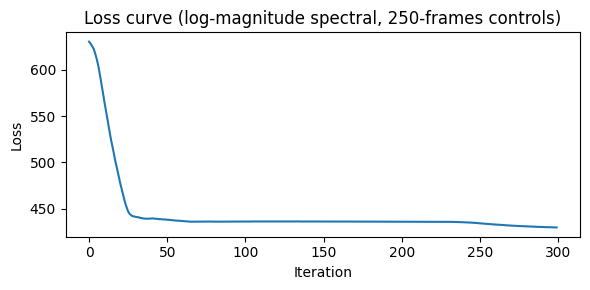

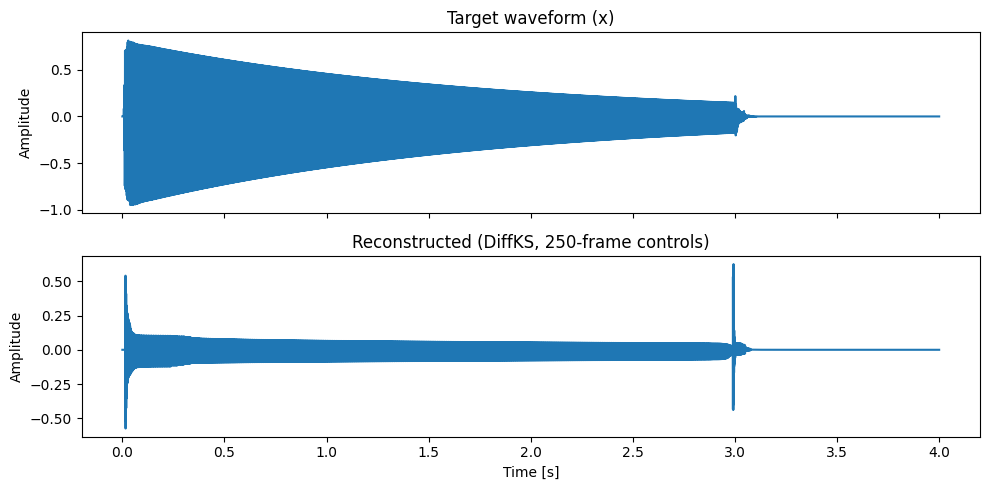


▶ Target waveform (x)



▶ Reconstructed DiffKS output


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Audio, display

import warnings
warnings.filterwarnings("ignore", message="Custom extension not loaded")
warnings.filterwarnings("ignore", message="Cannot find custom extension")

from ddsp.diff_ks import DiffKSIIRLoopLearnableCoefficients
from ddsp.metrics import LogMSSLoss

# --- Convert numpy → torch ---
x_tgt = torch.tensor(x, dtype=torch.float32).unsqueeze(0)            # [1, N]
noise_in = (torch.tensor(bursts, dtype=torch.float32).unsqueeze(0))  # [1, N]
N = x_tgt.shape[-1]

# --- Interpolate f0 to sample rate and Compute delay length (L = fs / f0)---
frame_hop = 4096
f0 = np.interp(np.arange(len(x)) / sr, np.arange(len(f0)) * frame_hop / sr, f0)
f0_n = sr / f0
f0_n = torch.tensor(f0_n, dtype=torch.float32).unsqueeze(0)  # [1, N]

# --- Initialize model, trainable params... ---
model = DiffKSIIRLoopLearnableCoefficients().to(torch.float32)
num_frames = 250
logits_frames = nn.Parameter(torch.zeros((1, num_frames, 2)))  # [1, F, 2]
optimizer = optim.AdamW([logits_frames], lr=5e-1)
loss_fn = LogMSSLoss() # Sm00th from "Revisited..."

# --- Training loop ---
num_iters = 300
loss_history = []

pbar = tqdm(range(num_iters), desc="Optimizing DiffKS (16-frame logits → upsampled)", ncols=100)
for i in pbar:
    optimizer.zero_grad()
    logits = F.interpolate(logits_frames.permute(0, 2, 1), size=N, mode="linear", align_corners=True).permute(0, 2, 1)
    y_pred = model(f0=f0_n, input=noise_in, params=logits)  # [1, N]
    loss = loss_fn(y_pred.unsqueeze(1), x_tgt.unsqueeze(1))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    pbar.set_postfix({"loss": f"{loss.item():.6f}"})

# --- Final output ---
y_out = y_pred.detach().cpu()[0]
y_tgt = x_tgt.detach().cpu()[0]

# --- Plot loss ---
plt.figure(figsize=(6, 3))
plt.plot(loss_history)
plt.title(f"Loss curve (log-magnitude spectral, {num_frames}-frames controls)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# --- Plot waveforms ---
plot_waveforms(
    [y_tgt, y_out],
    titles=["Target waveform (x)", f"Reconstructed (DiffKS, {num_frames}-frame controls)"],
    sample_rate=sr
)

print("\n▶ Target waveform (x)")
display(Audio(y_tgt, rate=sr))
print("\n▶ Reconstructed DiffKS output")
display(Audio(y_out, rate=sr))